In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
# read LMP data from csv into a new dataframe
prices = pd.read_csv('../data/prices_raw.csv')

# reindex and drop unused index columns
prices.index = pd.DatetimeIndex(start='2018-01-01 00:00:00',end='2018-07-31 23:00:00',freq='h')
prices = prices.drop(['Date','Hour Ending'],axis=1)

# interpolate over missing values (only 10 total)
prices = prices.interpolate(method='linear')

In [3]:
# load actual electricity demand data
elec = pd.read_csv('../data/elec_clean.csv',index_col=0)
elec.index = pd.to_datetime(elec.index,format='%Y-%m-%d %H:00:00')
elec.drop('Davenport',axis=1,inplace=True)
elec_total = pd.DataFrame(elec.sum(axis=1).values,columns=['Actual'],index=elec.index)

# load forecasted electricity demand data
forecast = pd.read_csv('../data/elec_forecast.csv',index_col=0)
forecast.index = pd.to_datetime(forecast.index,format='%Y-%m-%d %H:00:00')

In [18]:
# populate columns
totals = pd.DataFrame(forecast['aggregate_forecast'].values/1000,columns=['Forecast MWh'],index=forecast.index)
totals = totals.join(prices).join(elec_total/1000)

totals = totals.rename({'Day Ahead LMP':'DA $/MWh',
                        'Real Time LMP':'RT $/MWh',
                        'Actual':'Actual MWh',
                       },axis='columns')

totals['DA Charge $'] = (totals['Forecast MWh'])*totals['DA $/MWh']
totals['Error MWh'] = totals['Actual MWh'] - totals['Forecast MWh']
totals['RT Charge $'] = (totals['Error MWh'])*totals['RT $/MWh']
totals['Net Charge $'] = totals['DA Charge $'] + totals['RT Charge $']

totals = totals[['Forecast MWh','DA $/MWh','DA Charge $',
                 'Actual MWh','RT $/MWh','RT Charge $',
                 'Error MWh','Net Charge $']]

# totals.index.name = 'Date'

totals.head(5)

,Forecast MWh,DA $/MWh,DA Charge $,Actual MWh,RT $/MWh,RT Charge $,Error MWh,Net Charge $
2018-01-11 00:00:00,0.696068,70.44,49.031024,0.7109,59.18,0.877763,0.014832,49.908787
2018-01-11 01:00:00,0.682695,69.91,47.727188,0.7160,45.32,1.509395,0.033305,49.236583
2018-01-11 02:00:00,0.609783,64.01,39.032180,0.6386,29.07,0.837724,0.028817,39.869904
2018-01-11 03:00:00,0.688131,63.93,43.992244,0.6748,33.82,-0.450870,-0.013331,43.541374
2018-01-11 04:00:00,0.669462,67.33,45.074870,0.7055,54.12,1.950382,0.036038,47.025252


In [20]:
totals.groupby(totals.index.month).sum()

,Forecast MWh,DA $/MWh,DA Charge $,Actual MWh,RT $/MWh,RT Charge $,Error MWh,Net Charge $
1,444.731804,39893.08,35685.094183,447.2256,37239.40,279.613485,2.493796,35964.707667
2,601.455224,26426.32,24094.033553,601.6788,24686.83,42.751322,0.223576,24136.784875
3,621.699142,26154.37,21846.383937,624.1830,24231.64,82.329747,2.483858,21928.713684
4,632.933227,32010.74,28395.857286,633.2550,30691.37,55.463594,0.321773,28451.320880
5,597.202110,17999.38,14908.635150,600.3641,17881.53,198.384240,3.161990,15107.019391
6,552.261841,19700.05,15703.390107,554.2855,18901.49,126.574870,2.023659,15829.964977
7,210.675388,9520.01,8044.089318,212.6156,10578.45,28.569564,1.940212,8072.658883


12.64886368568639

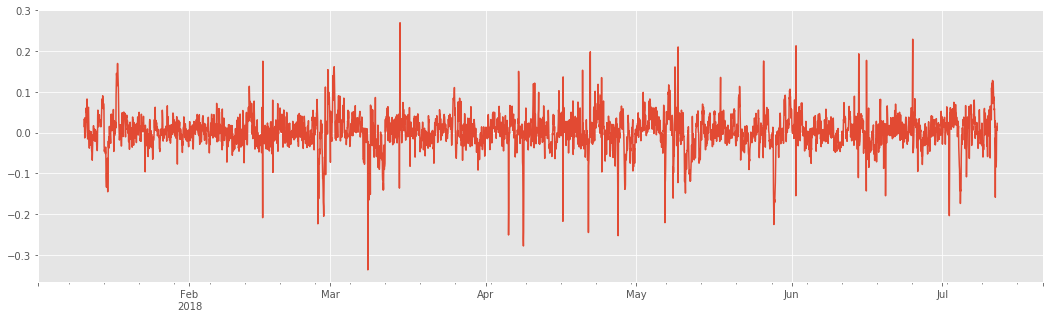

In [7]:
# totals['Net Charge $'].plot(figsize=(18,5))
totals['Error MWh'].plot(figsize=(18,5))

totals['Error MWh'].sum()

In [12]:
avg_rate = np.round((totals['Net Charge $'].sum()/totals['Actual MWh'].sum()),2)
rate_estimate = 60 # estimate for yale's current rate in $/MWh

savings = np.round(((rate_estimate - avg_rate) * totals['Actual MWh'].sum()),2)
yearly_savings = np.round(savings*(8760/len(totals)),2)

print('The average day-ahead rate is {} $/MWh.\n'
      .format(avg_rate))
print('Assuming a current rate of {} $/MWh, this strategy would save ${} per year.'
      .format(rate_estimate, yearly_savings))


The average day-ahead rate is 40.69 $/MWh.

Assuming a current rate of 60 $/MWh, this strategy would save $142264.49 per year.
